In [5]:
import kagglehub
import os

path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)


print("Contents of downloaded folder:")
print(os.listdir(path))

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals
Contents of downloaded folder:
['animals', 'name of the animals.txt']


In [6]:
import kagglehub
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")
dataset_path = os.path.join(path, "animals", "animals")

image_size = (64, 64)

def load_animal_images(path, max_per_class=100):
    gray_imgs, color_imgs, labels = [], [], []
    label_map = {}
    current_label = 0

    for folder in sorted(os.listdir(path)):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path): continue

        count = 0
        print(f"Loading class '{folder}'...")

        for file in os.listdir(folder_path):
            if count >= max_per_class:
                break

            file_path = os.path.join(folder_path, file)

            img = cv2.imread(file_path)
            if img is None:
                print(f"skipped unreadable image: {file_path}")
                continue

            try:
                img = cv2.resize(img, image_size)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            except Exception as e:
                print(f"error processing {file_path}: {e}")
                continue

            color_imgs.append(img / 255.0)
            gray_imgs.append(np.expand_dims(gray / 255.0, axis=-1))

            if folder not in label_map:
                label_map[folder] = current_label
                current_label += 1
            labels.append(label_map[folder])
            count += 1

        print(f"Loaded {count} images from '{folder}'")

    if len(gray_imgs) == 0:
        raise ValueError("no images loaded")

    return (
        np.array(gray_imgs, dtype=np.float32),
        np.array(color_imgs, dtype=np.float32),
        to_categorical(labels, num_classes=current_label),
        label_map
    )

gray_images, color_images, label_cats, label_map = load_animal_images(dataset_path)

print("gray images:", gray_images.shape)
print("color images:", color_images.shape)
print("labels(One-hot):", label_cats.shape)
print("class mapp:", label_map)



Loading class 'antelope'...
Loaded 60 images from 'antelope'
Loading class 'badger'...
Loaded 60 images from 'badger'
Loading class 'bat'...
Loaded 60 images from 'bat'
Loading class 'bear'...
Loaded 60 images from 'bear'
Loading class 'bee'...
Loaded 60 images from 'bee'
Loading class 'beetle'...
Loaded 60 images from 'beetle'
Loading class 'bison'...
Loaded 60 images from 'bison'
Loading class 'boar'...
Loaded 60 images from 'boar'
Loading class 'butterfly'...
Loaded 60 images from 'butterfly'
Loading class 'cat'...
Loaded 60 images from 'cat'
Loading class 'caterpillar'...
Loaded 60 images from 'caterpillar'
Loading class 'chimpanzee'...
Loaded 60 images from 'chimpanzee'
Loading class 'cockroach'...
Loaded 60 images from 'cockroach'
Loading class 'cow'...
Loaded 60 images from 'cow'
Loading class 'coyote'...
Loaded 60 images from 'coyote'
Loading class 'crab'...
Loaded 60 images from 'crab'
Loading class 'crow'...
Loaded 60 images from 'crow'
Loading class 'deer'...
Loaded 60 image

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical
import kagglehub

gray_train, gray_test, color_train, color_test, y_train, y_test = train_test_split(
    gray_images, color_images, label_cats, test_size=0.1, shuffle=True
)

In [8]:
input_layer = Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2,2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same", activation="relu")(encoded)
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same", name="dec_output")(x)

# Classifier
y = layers.Conv2D(32, (3,3), activation="relu", padding="same")(decoded)
y = layers.Conv2D(64, (3,3), activation="relu", padding="same")(y)
y = layers.Conv2D(128, (3,3), activation="relu", padding="same")(y)
y = layers.MaxPooling2D((2,2), padding="same")(y)
y = layers.Flatten()(y)
y = layers.Dense(64, activation="relu")(y)
output_class = layers.Dense(len(label_map), activation="softmax", name="class_output")(y)

model = models.Model(inputs=input_layer, outputs=[decoded, output_class])
model.compile(
    optimizer='adam',
    loss={
        'dec_output': 'mse',
        'class_output': 'categorical_crossentropy'
    },
    metrics={'class_output': 'accuracy'}
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Conv2D)             │ (None, 64, 64, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     8,388,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_output (Dense)            │ (None, 90)             │         5,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,821,149 (33.65 MB)

 Trainable params: 8,821,149 (33.65 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.fit(
    x=gray_train,
    y={'dec_output': color_train, 'class_output': y_train},
    epochs=25,
    batch_size=128,
    validation_data=(gray_test, {'dec_output': color_test, 'class_output': y_test})
)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - class_output_accuracy: 0.0089 - class_output_loss: 4.5435 - dec_output_loss: 0.0730 - loss: 4.6165 - val_class_output_accuracy: 0.0093 - val_class_output_loss: 4.4983 - val_dec_output_loss: 0.0254 - val_loss: 4.5241
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 264ms/step - class_output_accuracy: 0.0110 - class_output_loss: 4.4976 - dec_output_loss: 0.0234 - loss: 4.5210 - val_class_output_accuracy: 0.0185 - val_class_output_loss: 4.4675 - val_dec_output_loss: 0.0303 - val_loss: 4.5016
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - class_output_accuracy: 0.0220 - class_output_loss: 4.4566 - dec_output_loss: 0.0257 - loss: 4.4822 - val_class_output_accuracy: 0.0241 - val_class_output_loss: 4.4176 - val_dec_output_loss: 0.0317 - val_loss: 4.4368
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - class_output_accuracy: 0.0420 - class_output_loss: 4.3085 - dec_output_loss: 0.0253 - loss: 4.3337 - val_class_output_accuracy: 0.0500 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


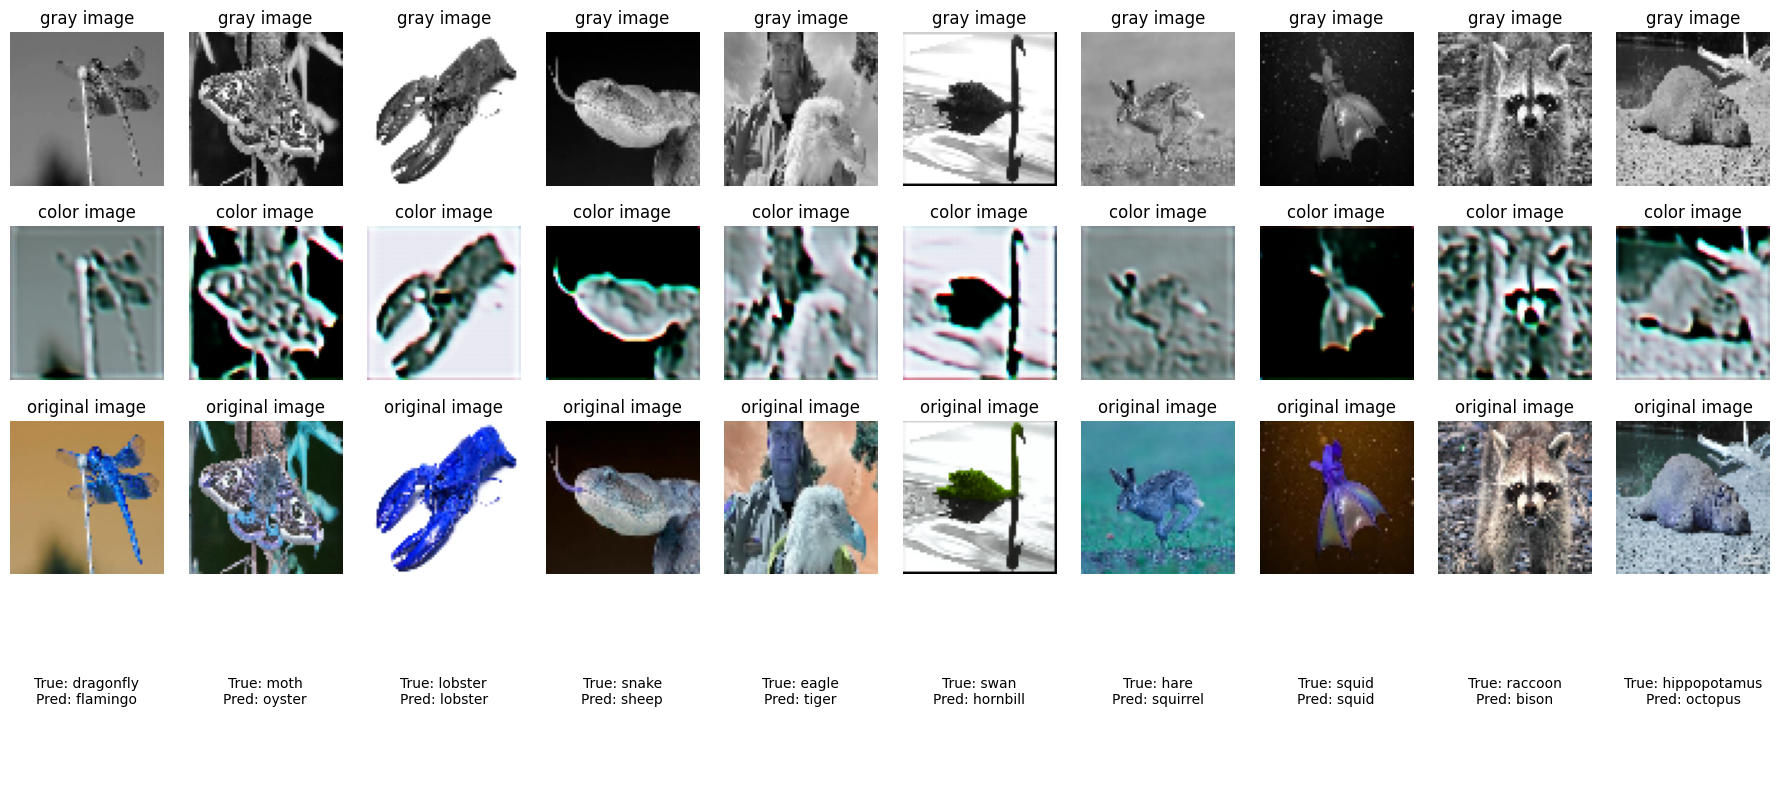

In [11]:
decoded_imgs, class_preds = model.predict(gray_test[:10])
predicted_classes = np.argmax(class_preds, axis=1)
true_classes = np.argmax(y_test[:10], axis=1)

inv_label_map = {v: k for k, v in label_map.items()}

plt.figure(figsize=(18, 8))
for i in range(10):
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(gray_test[i].reshape(64, 64), cmap="gray")
    plt.title("gray image")
    plt.axis("off")

    ax = plt.subplot(4, 10, i + 11)
    plt.imshow(decoded_imgs[i])
    plt.title("color image")
    plt.axis("off")

    ax = plt.subplot(4, 10, i + 21)
    plt.imshow(color_test[i])
    plt.title("original image")
    plt.axis("off")

    ax = plt.subplot(4, 10, i + 31)
    plt.text(0.5, 0.5,
             f"True: {inv_label_map[true_classes[i]]}\nPred: {inv_label_map[predicted_classes[i]]}",
             ha="center", va="center", wrap=True)
    plt.axis("off")

plt.tight_layout()
plt.show()